
### 2023년 07월 05일 :  데이터 처리

(1) 2차 데이터 정비로 확정한 변수들의 데이터 로드를 확인하고

(2) 계절조정이 되지 않은 계열에 대하여 X13-arima_analsis 를 이용하여 계절조정을 시행한다.

(3) 또한 lag가 있는 경우 이를 데이터 셋에 반영한다.

In [2]:
# colab 한글 font 사용을 위한 font 설치
# install 후 restart session
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
# 구글 드라이브와 연결
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
from datetime import datetime as dt
import time

import numpy as np
import pandas as pd
import openpyxl
import pprint as pp

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Python set up modules loaded")
print("Python version:\n", os.sys.version, "\nPlatform: ", os.sys.platform)
print("Base directory path:", os.getcwd())
print("Data/time:", dt.now())

import statsmodels as sma
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

print("STATSMODELS info (statsmodels._version.version)", sma._version.version)

Python set up modules loaded
Python version:
 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)] 
Platform:  win32
Base directory path: d:\venv\jupyter_lab\source\X13_arima_sadj
Data/time: 2023-07-06 23:13:22.196670
STATSMODELS info (statsmodels._version.version) 0.14.0


In [3]:
# 데이터 저장 위치에 excel files  확인
data_path = 'D:/2023/Data_WareHouse/ECOS(한국은행경제통계)/Data_02'
data_list = [file for file in os.listdir(data_path) if file.endswith(".xlsx")]
data_list.sort()
for d, f in enumerate(data_list):
  print(data_list[d])

M2.xlsx
dataset_01.xlsx
계열정리.xlsx
기계수주액_01134039.xlsx
변수목록_d.xlsx
복수통계_01140009.xlsx
선택계열.xlsx
신용카드_01140906.xlsx
아파트 매매 실거래가격지수_01135002.xlsx


In [4]:
# dataset_01.xlsx file 안에 있는 sheet에서 사용할 계열(입력 데이터 variable) 확을 위한 sheet 를 load
var_info = pd.read_excel(os.path.join(data_path,data_list[1]),sheet_name=0,header=0)
print(var_info.head(),"\n")

# dataset variable list
var_list = var_info['Variable'].iloc[1:]

Sadj=var_info['계절조정'][1:]
x13_arima=var_info['X13-arima'][1:]
print(f"전체 사용 변수의 개수 -------------- {len(Sadj)}")
print(f"계절조정 된 계열의 개수 ------------ {len(Sadj) - sum(Sadj.isna())}")
print(f"계절조정 되지 않은 계열의 개수 ----- {sum(Sadj.isna())}")
print(f"X13-arima로 계열조정 해야 하는 개수- {sum(x13_arima == 'o')}")

    NO Group    Variable   단위  FEQ  LAG 계절조정 X13-arima               비고
0  NaN   NaN         NaN  NaN  NaN  NaN  NaN       NaN              NaN
1  1.0  주요지표  국내총생산(GDP)   %     Q  2.0    o         x  (실질, 계절조정, 전기비)
2  2.0   NaN        민간소비   %     Q  2.0    o         x  (실질, 계절조정, 전기비)
3  3.0   NaN        설비투자   %     Q  2.0    o         x  (실질, 계절조정, 전기비)
4  4.0   NaN        건설투자   %     Q  2.0    o         x  (실질, 계절조정, 전기비) 

전체 사용 변수의 개수 -------------- 102
계절조정 된 계열의 개수 ------------ 102
계절조정 되지 않은 계열의 개수 ----- 0
X13-arima로 계열조정 해야 하는 개수- 61


In [ ]:
dataset_Q = pd.read_excel(os.path.join(data_path,data_list[1]),sheet_name=2,header=1)
print(dataset_Q.head())
col_Q = dataset_Q.columns
print(f"\n변수의 개수 -------------- {len(col_Q)}")
print(f"데이터의 길이 ------------ {len(dataset_Q.iloc[2:])}")
for i, col in enumerate(col_Q):
  print(f"{col}계열의 NaN 개수 ----- {sum(dataset_Q[col].iloc[2:].isna())}")

print(f"\n{dataset_Q.iloc[2:3]}")
print(f"\n{dataset_Q.iloc[-1:]}")

        년월 국내총생산(GDP) 민간소비  설비투자  건설투자  재화수출  재화수입
0       단위         %    %     %     %     %     % 
1  1960/Q1        NaN  NaN   NaN   NaN   NaN   NaN
2  1960/Q2        4.5  5.4  15.6   3.5  34.1     1
3  1960/Q3       -1.1   -4   -14 -16.7  -5.5 -25.1
4  1960/Q4        0.6  3.9   2.2   -10  17.3   5.7

변수의 개수 -------------- 7
데이터의 길이 ------------ 255
년월계열의 NaN 개수 ----- 0
국내총생산(GDP)계열의 NaN 개수 ----- 3
민간소비계열의 NaN 개수 ----- 3
설비투자계열의 NaN 개수 ----- 3
건설투자계열의 NaN 개수 ----- 3
재화수출계열의 NaN 개수 ----- 3
재화수입계열의 NaN 개수 ----- 3

        년월 국내총생산(GDP) 민간소비  설비투자 건설투자  재화수출 재화수입
2  1960/Q2        4.5  5.4  15.6  3.5  34.1    1

          년월 국내총생산(GDP) 민간소비 설비투자 건설투자 재화수출 재화수입
256  2023/Q4        NaN  NaN  NaN  NaN  NaN  NaN


In [ ]:
# 계열 time index 및 길이 조정
p_rng = pd.period_range('1960Q2', '2023Q1', freq='Q-FEB')
df_Q = dataset_Q.iloc[2:254].set_index(p_rng)
df_Q = df_Q.iloc[:,1:].astype('float')
df_Q.index.name = '년월'
df_Q

,국내총생산(GDP),민간소비,설비투자,건설투자,재화수출,재화수입
년월,,,,,,
1960Q2,4.5,5.4,15.6,3.5,34.1,1.0
1960Q3,-1.1,-4.0,-14.0,-16.7,-5.5,-25.1
1960Q4,0.6,3.9,2.2,-10.0,17.3,5.7
1961Q1,3.2,0.9,0.6,24.5,5.9,8.9
1961Q2,4.3,-1.0,4.8,1.7,-6.0,14.2
...,...,...,...,...,...,...
2022Q1,0.7,-0.6,-4.2,-2.5,4.2,0.0
2022Q2,0.8,2.9,1.6,-0.6,-2.6,-1.8
2022Q3,0.2,1.6,7.0,-0.1,0.2,5.7


In [ ]:
df_Q.describe()

,국내총생산(GDP),민간소비,설비투자,건설투자,재화수출,재화수입
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.721825,1.407937,3.104762,2.283730,4.050794,2.880159
std,1.976505,1.966355,9.667239,8.728281,7.576670,9.257709
min,-6.800000,-13.800000,-24.900000,-27.000000,-18.500000,-33.200000
25%,0.700000,0.600000,-1.650000,-1.500000,0.375000,-0.825000
50%,1.550000,1.300000,1.900000,1.200000,2.900000,2.600000
75%,2.900000,2.325000,7.525000,4.200000,6.500000,6.400000
max,8.100000,9.400000,54.500000,35.000000,60.100000,61.300000


In [ ]:
dataset_M = pd.read_excel(os.path.join(data_path,data_list[1]),sheet_name=3,header=1)
print(dataset_M.head())
col_M = dataset_M.columns
print(f"\n변수의 개수 -------------- {len(col_M)}")
print(f"데이터의 길이 ------------ {len(dataset_M.iloc[2:])}")
# for i, col in enumerate(col_M):
  # print(f"{col}계열의 NaN 개수 ----- {sum(dataset_M[col].iloc[2:].isna())}")
# print(f"\n{dataset_M.iloc[2:3]}")
# print(f"\n{dataset_M.iloc[-1:]}")

        년월 선행종합지수_순환변동치 동행종합지수-순환변동치 전산업_(농림어업 제외)   광공업   건설업   서비스업  \
0       단위           지수           지수            지수    지수    지수     지수   
1       변환          원자료          원자료           원자료   원자료   원자료    원자료   
2  1970/01          101        100.6           NaN   NaN   NaN    NaN   
3  1970/02        100.9        101.5           NaN   NaN   NaN    NaN   
4  1970/03        100.8        101.9           NaN   NaN   NaN    NaN   

  제조업_생산자제품_출하지수 제조업_생산자제품_재고지수 제조업_가동률지수  ... 신용카드대출_연체율   KOSPI_시가총액  \
0             지수             지수        지수  ...         %           천원    
1            원자료            원자료       원자료  ...        원자료          원자료   
2            NaN            NaN       NaN  ...        NaN          NaN   
3            NaN            NaN       NaN  ...        NaN          NaN   
4            NaN            NaN       NaN  ...        NaN          NaN   

    KOSPI_거래량   KOSPI_거래대금   KOSDAQ_시가총액   KOSDAQ_거래량   KOSDAQ_거래대금 채권_상장잔액  \
0          주           천원            

In [ ]:
# 계열 time index 및 길이 조정
date = pd.to_datetime(dataset_M['년월'][2:])
df_M = dataset_M.iloc[2:].set_index(date)
df_M = df_M.iloc[:,1:].astype('float')
df_M.index.name = '년월'
df_M

,선행종합지수_순환변동치,동행종합지수-순환변동치,전산업_(농림어업 제외),광공업,건설업,서비스업,제조업_생산자제품_출하지수,제조업_생산자제품_재고지수,제조업_가동률지수,소매판매액지수(총지수),...,신용카드대출_연체율,KOSPI_시가총액,KOSPI_거래량,KOSPI_거래대금,KOSDAQ_시가총액,KOSDAQ_거래량,KOSDAQ_거래대금,채권_상장잔액,채권_거래량,채권_거래대금
년월,,,,,,,,,,,,,,,,,,,,,
1970-01-01,101.0,100.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-01,100.9,101.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-01,100.8,101.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,100.6,103.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,100.5,103.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,98.4,99.2,110.1,99.0,106.6054,116.4,97.4,119.0,96.5,107.6,...,1.7,1.906496e+12,9.658016e+09,1.603751e+11,3.719130e+11,2.335491e+10,1.925959e+11,2.400031e+09,76914960.0,77551528.0
2023-03-01,98.2,99.7,111.4,104.2,102.0678,115.8,100.8,118.1,101.3,107.7,...,1.5,1.957926e+12,1.007835e+10,1.965661e+11,3.990974e+11,2.629994e+10,2.802401e+11,2.412701e+09,96756124.0,97609811.0
2023-04-01,98.0,99.9,109.8,102.9,103.3226,115.4,96.2,125.4,100.1,105.2,...,NaN,1.979839e+12,1.670147e+10,2.518095e+11,4.013092e+11,3.180945e+10,2.762895e+11,2.431706e+09,89118276.0,90658204.0


In [ ]:
df_M.describe()

,선행종합지수_순환변동치,동행종합지수-순환변동치,전산업_(농림어업 제외),광공업,건설업,서비스업,제조업_생산자제품_출하지수,제조업_생산자제품_재고지수,제조업_가동률지수,소매판매액지수(총지수),...,신용카드대출_연체율,KOSPI_시가총액,KOSPI_거래량,KOSPI_거래대금,KOSDAQ_시가총액,KOSDAQ_거래량,KOSDAQ_거래대금,채권_상장잔액,채권_거래량,채권_거래대금
count,640.000000,640.000000,280.000000,280.000000,280.000000,280.000000,520.000000,520.000000,520.000000,340.000000,...,218.000000,2.210000e+02,2.210000e+02,2.210000e+02,2.330000e+02,2.330000e+02,2.330000e+02,1.970000e+02,1.970000e+02,1.970000e+02
mean,100.284219,100.245781,83.888571,81.736786,87.334307,84.691071,54.892310,49.547829,106.917498,74.312059,...,1.923394,1.225686e+12,9.621031e+09,1.293189e+11,1.694386e+11,1.533445e+10,7.773220e+10,1.504317e+09,1.205658e+08,1.210745e+08
std,2.282776,1.953020,16.349909,20.329643,11.270357,15.872133,34.781698,30.993166,6.520103,19.766842,...,0.800261,4.459306e+11,4.904664e+09,7.081515e+10,1.115793e+11,8.682389e+09,6.875946e+10,4.587415e+08,7.897373e+07,7.980345e+07
min,91.800000,93.000000,52.500000,44.800000,58.916200,55.000000,6.558000,6.653000,86.147000,40.700000,...,0.100000,4.226400e+11,3.763932e+09,3.740209e+10,2.710246e+10,4.139789e+09,9.035163e+09,7.824629e+08,1.957878e+07,1.897600e+07
25%,99.300000,99.200000,69.350000,62.350000,80.106875,69.475000,21.851500,22.637000,103.724500,60.275000,...,1.600000,9.042962e+11,6.712882e+09,8.810944e+10,8.494023e+10,9.941983e+09,3.500367e+10,1.132000e+09,5.362002e+07,5.417861e+07
50%,100.200000,100.100000,87.800000,92.000000,86.056650,87.050000,51.662500,43.126500,108.219000,72.350000,...,1.800000,1.192617e+12,8.288867e+09,1.091885e+11,1.245730e+11,1.319057e+10,5.259801e+10,1.495359e+09,1.091518e+08,1.083814e+08
75%,101.000000,101.300000,98.225000,97.725000,95.194325,97.825000,94.998000,76.849750,111.760750,91.600000,...,2.100000,1.448767e+12,1.047213e+10,1.445572e+11,2.324615e+11,1.731343e+10,8.567499e+10,1.780662e+09,1.626088e+08,1.640880e+08
max,110.500000,106.100000,111.400000,115.500000,116.371300,116.400000,106.400000,125.400000,118.183000,108.300000,...,8.500000,2.309063e+12,3.535454e+10,5.295564e+11,4.462970e+11,5.549486e+10,3.241969e+11,2.460581e+09,5.117159e+08,5.199584e+08


<Axes: xlabel='년월'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


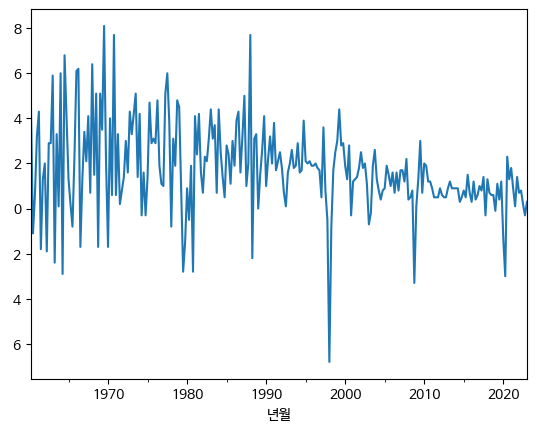

In [ ]:
df_Q['국내총생산(GDP)'].plot()

In [ ]:
# cols_M = df_M.columns
# print(cols_M[59])
# print(len(var))
var = '기계수주액'
# var_info['X13-arima'][var_info['Variable']==var].values[0]

# df_M['기계수주액']
# sadj = sm.tsa.x13_arima_analys()

# var_info['FEQ'][var_info['Variable']==var]

data = df_M[var].dropna()

# sadj_model = sm.tsa.x13_arima_analysis(data)
# sm.tsa.x13_arima_analysis


x_paht =

res = sm.tsa.x13_arima_select_order(data, x12path=x_path, prefer_x13=True)
print(res.order, res.sorder)

results = sm.tsa.x13_arima_analysis(data)

fig = results.plot()
fig.set_size_inches(12, 5)
fig.tight_layout()

X13NotFoundError: ignored

In [ ]:
for i, var in enumerate(df_M.columns):
  # print(i)
  if atr := var_info['X13-arima'][var_info['Variable']==var].values[0] == 'o':
    print(var)


  else:
    continue
print(i+1)

기계수주액
미분양주택현황
주택건설인허가실적
아파트 매매 실거래가격지수
신용카드 이용건수
신용카드 이용금액
소비자동향조사_CSI
(현재경기판단)
전산업(업황실적)
전산업(매출실적)
제조업(업황실적)
제조업(매출실적)
제조업(수출실적)
제조업(가동률실적)
제조업(설비투자실적)
경제심리지수(순환변동치)
기대인플레이션율
원/달러(종가,말일) 환율
국별수출(관세청 통관기준)
국별수입(관세청 통관기준)
수출금액지수
수입금액지수
외환보유액
수출물가지수
수입물가지수
본원통화(말잔)
M1(말잔)
M2(말잔)
Lf(말잔)
L(광의유동성)(말잔)
한국은행 기준금리
예금은행 총대출 금리
기업대출 금리
주택담보대출 금리
전세자금대출 금리
무담보콜금리 전체 금리
KORIBOR(3개월) 금리
CD(91일) 금리
CP(91일) 금리
국고채(1년) 금리
국고채(10년) 금리
회사채(3년, AA-) 금리
예금은행 총수신(말잔)
비은행기관 수신(말잔)
예금은행 대출금(말잔)
비은행금융기관 여신(말잔)
 가계대출
  (가계)주택담보대출
  (가계)기타대출
예금은행예금회전율
기업대출 연체율
가계대출_연체율
신용카드대출_연체율
  KOSPI_시가총액
  KOSPI_거래량
  KOSPI_거래대금
  KOSDAQ_시가총액
  KOSDAQ_거래량
  KOSDAQ_거래대금
채권_상장잔액
채권_거래량
채권_거래대금
96


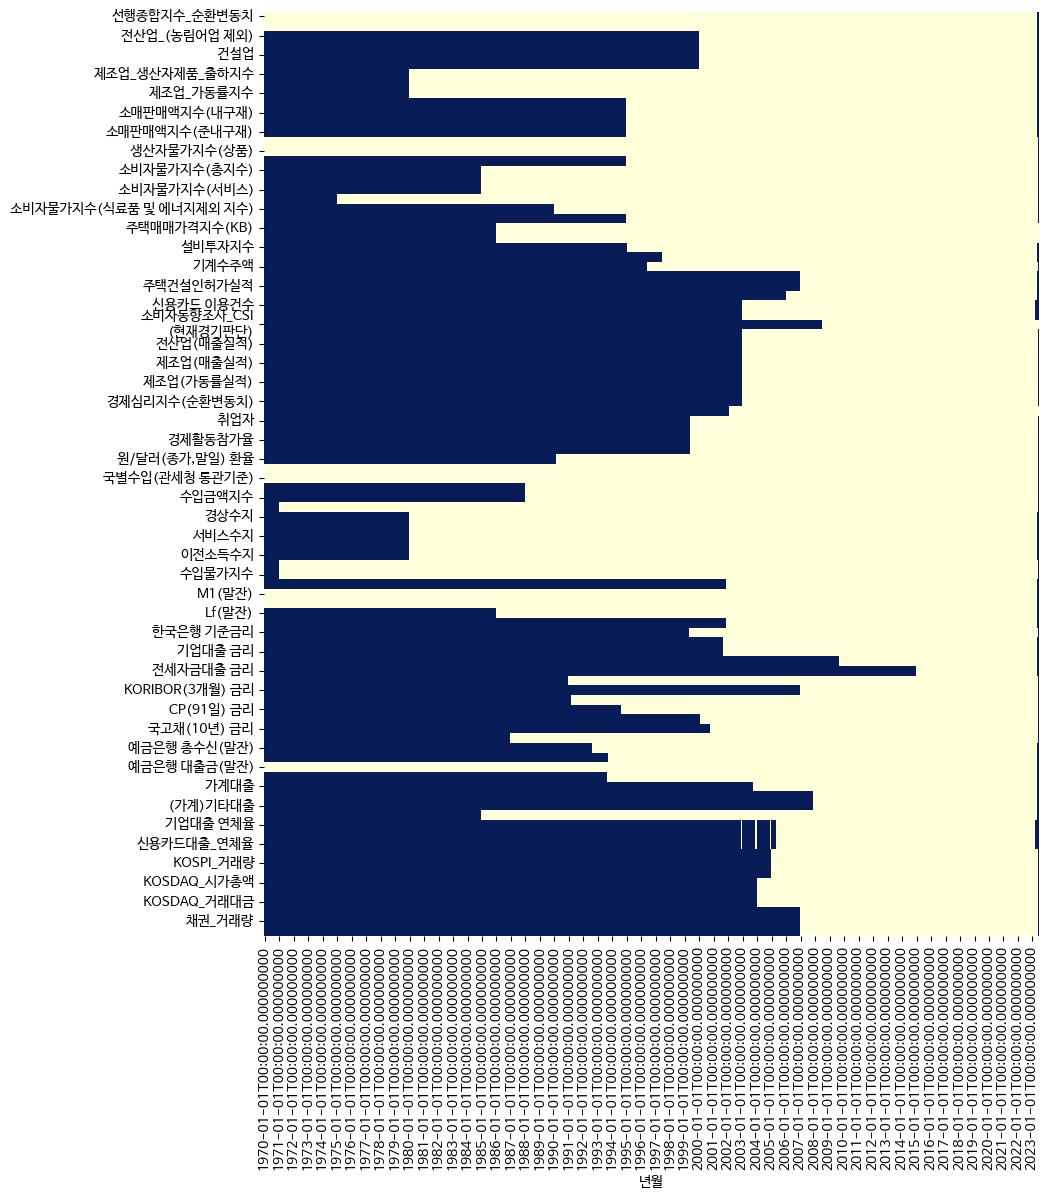

In [ ]:


plt.figure(figsize=(10,12))
# sns.heatmap(df_M.isnull(), cbar=False, cmap="YlGnBu")

sns.heatmap(df_M.isna().transpose(),
            cmap="YlGnBu",
            cbar=False,
            # cbar_kws={'label': 'Missing Data'}
            )

# sns.displot(
#     data=df_M.isna().melt(value_name="missing"),
#     y="variable",
#     hue="missing",
#     multiple="fill",
#     aspect=1.25
# )

plt.show()

In [ ]:
# 전체 데이터 adf_test

def adf_test(transformed):
  if (result := adfuller(transformed.values))[1] < 0.05 :
    test_result = "{}".format("S")
  else:
    test_result = "{}".format("N")
  return test_result

save_dir= '/content/drive/MyDrive/ZZ/Code_02/base_data'
save_file = 'val_adf_test.xlsx'
save_path = os.path.join(save_dir,save_file)

trans = ['Origin','Diff-1','Log-1','Diff-2']
start = '1995-01'
end = '2023-06'

adf_test_result = []
i = 0

## temporal pass
for var in var_list:
  for t in trans:
    i += 1
    print(f"processing....{i}.... [ {var} ------ {col} ------ {t} ---- ]")
    # test
    if t == 'Origin':
      if var_info['FEQ'][var_info['Variable']==var]
      transformed = df_Q[var].loc[start:end].dropna()
      res = adf_test(transformed)

        elif t == 'Diff-1':
          transformed = globals()[var][col].loc[start:end].diff().dropna()
          res = adf_test(transformed)

        elif t == 'Log-1':
          # error transform log list
          if col in ['(경제활동별 성장률)비농림어업GDP(실질, 계절조정, 전기비)',
                     '(경제활동별 성장률)농림어업(실질, 계절조정, 전기비)',
                     '(경제활동별 성장률)제조업(실질, 계절조정, 전기비)',
                     '(경제활동별 성장률)서비스업(실질, 계절조정, 전기비)',
                     '(경제활동별 성장률)ICT산업(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)민간소비(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)설비투자(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)건설투자(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)재화수출(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)재화수입(실질, 계절조정, 전기비)',
                     '(지출항목별 증감율)내수(재고제외)(실질, 계절조정, 전기비)',
                     '(경제활동별 성장률)전기, 가스 및 수도사업(실질, 원계열, 전년동기비)',
                     '(지출항목별 증감율)건설투자(실질, 원계열, 전년동기비)',
                     '실질 GNI(계절조정, 전기비)',
                     '명목 GNI(원계열, 전년동기비)',
                     '실질 GNI(원계열, 전년동기비)',
                     'GDP 디플레이터 등락률(원계열, 전년동기비)',
                     '특별자금','국민투자기금','자유저축예금','외국채(상장종목수)','외국채(상장잔액)','외국채(거래량)','외국채(거래대금)','자본수지',

                    ]:
            res = 'X'
          else:
            log_1 = globals()[var][col].loc[start:end]
            transformed = np.log(log_1).dropna()
            res = adf_test(transformed)

        elif t == 'Diff-2':
          transformed = globals()[var][col].loc[start:end].diff().diff().dropna()
          res = adf_test(transformed)

        else:
          pass

        test_result = [var,col,t,res]
        adf_test_result.append(test_result)

df_adf_test_result = pd.DataFrame(adf_test_result,columns = ['Group','variable','transform','adf'] )
df_adf_test_pivot = df_adf_test_result.pivot(index= ['Group','variable'], columns='transform', values='adf')
df_adf_test_pivot.to_excel(save_path)

In [ ]:

# save_dir= '/content/drive/MyDrive/ZZ/Data/adj_data'
# save_file = 'ssm_data_v01.xlsx'
# save_path = os.path.join(save_dir,save_file)

# sheet = 'GDP_Q_index_2'

# if not os.path.exists(save_path):
#     with pd.ExcelWriter(save_path, mode='w', engine='openpyxl') as writer:
#         df.to_excel(writer, index=True, sheet_name=sheet)
# else:
#     with pd.ExcelWriter(save_path, mode='a', engine='openpyxl') as writer:
#         df.to_excel(writer, index=True, sheet_name=sheet)